# Library Imports

In [1]:
import string
import tqdm
import os
import PIL
import matplotlib.pyplot as plt
from os import listdir
from pickle import dump
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
%matplotlib inline

# Some Sample Images from the Dataset


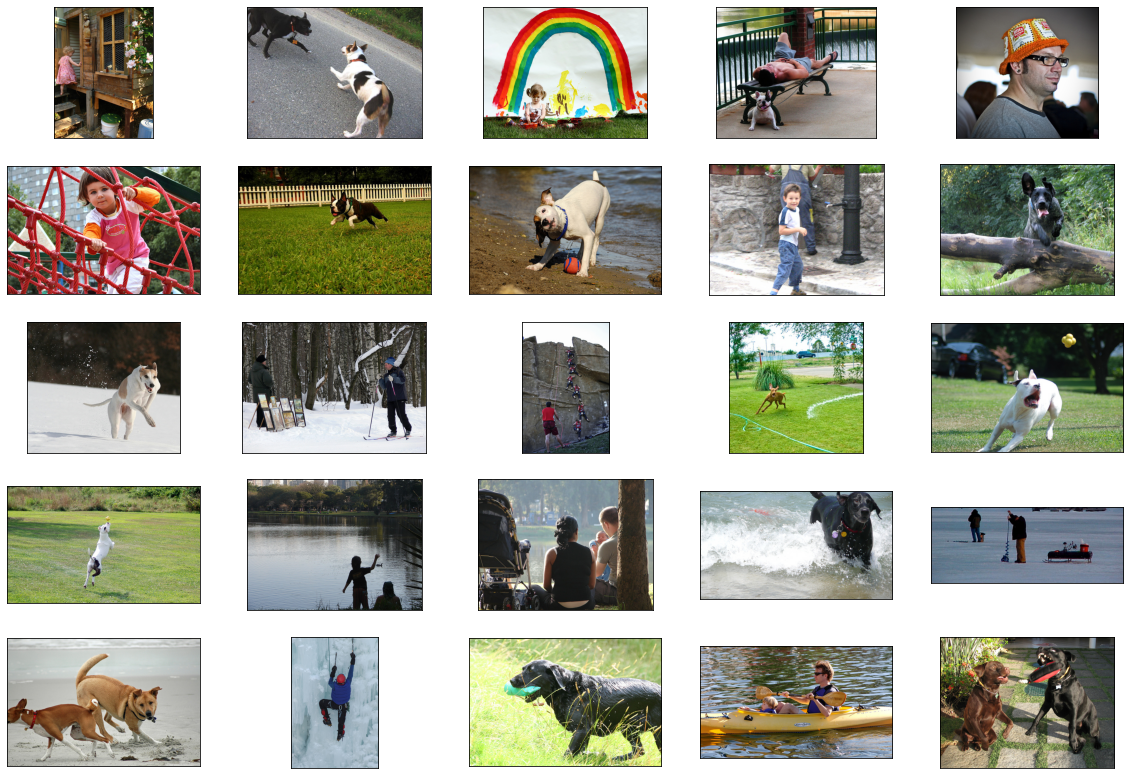

In [2]:
#displaying a sample of images
fig, axes = plt.subplots(5, 5, figsize=(20, 14))
sample = listdir('Flicker8k_Dataset')[0:25]
for i in range(0, 5):
    for j in range(0, 5):
        axes[i][j].imshow(PIL.Image.open('Flicker8k_Dataset/'+sample[i*5+j]))
        axes[i][j].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

# Extracting Image Features
We'll be using the simple [VGG16](https://neurohive.io/en/popular-networks/vgg16/) (by Oxford Visual Geometry Group) to extract the features of images from the dataset. It's a very known model which had in the past won the Imagenet Challenge in the year 2014. Extracting the features would allow us to represent and interpret the image as a one dimensional element vector.

In [3]:
#some required variables
dataset_path = 'Flicker8k_Dataset'
features_path = 'Utility/features.pkl'
features = {}

In [4]:
#loading and restructuring VGG16
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

While restructuring, we do not have to consider the last layer of VGG16 model which basically has the task of predicting the class of the image, i.e. to do the classification. Since we are only interested in the feature encodings we will skip the last layer.   

In [5]:
#extracting the features
for name in tqdm.tqdm(listdir(dataset_path)):
    file_path = os.path.join(dataset_path, name)
    image = load_img(file_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = name.split('.')[0]
    features[image_id] = feature

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [07:32<00:00, 17.88it/s]


In [6]:
#saving the extracted features so we can use them as per our convenience
dump(features, open(features_path, 'wb'))

# Preprocessing Captions
Each image is provided with 5 captions. Steps that will be followed are:
* Loading the Captions
* Cleaning the Descriptions
* Creating a Voabulary

Additionally text preprocessing can be referred at [How to Clean Text for Machine Learning with Python](https://machinelearningmastery.com/clean-text-machine-learning-python/).

In [7]:
#some required variables
caption_path = 'Flickr8k_text/Flickr8k.token.txt'
description_path = 'Utility/descriptions.txt'
vocabulary_path = 'Utility/vocabulary.pkl'
mapping_dict = {}

## Loading the Captions

In [8]:
#loading the captions
with open(caption_path, 'r') as file:
    text = file.read()

In [9]:
#getting a look at the captions
for i in range(0, 10):
    print(text.split('\n')[i])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


In [10]:
#mapping captions to their images
for line in text.split('\n'):
    tokens = line.split()
    #to avoid issues caused by an abnormal line in the text file
    if len(line)<2:
        continue
    image_id, image_desc = tokens[0], tokens[1: ]
    image_id = image_id.split('.')[0]
    image_desc = ' '.join(image_desc)
    if image_id not in mapping_dict:
        mapping_dict[image_id] = []
    mapping_dict[image_id].append(image_desc)

## Cleaning the Descriptions
It can be divided as follows:
* Convert all words to lowercase
* Remove all punctuation
* Remove all words that are one character or less in length
* Remove all words with number in them

Ideally a vocabulary that is both expressive and as small as possible would be best as it will allow us to train the model faster.

In [11]:
#creating a translation table
table = str.maketrans('', '', string.punctuation)

In [12]:
#cleaning the descriptions
for _, desc_list in mapping_dict.items():
    for i in range(0, len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [word.translate(table) for word in desc]
        desc = [word for word in desc if len(word)>1]
        desc = [word for word in desc if word.isalpha()]
        desc_list[i] = ' '.join(desc)

## Creating a Vocabulary

In [13]:
#creating a vocabulary of words
vocabulary = set()
for key in mapping_dict.keys():
    [vocabulary.update(desc.split()) for desc in mapping_dict[key]]

In [14]:
#checking out the size of our vocabulary
len(vocabulary)

8763

In [15]:
#checking out the words in the vocabulary
print(vocabulary)

{'because', 'equestrian', 'stool', 'undershirt', 'cloaks', 'dribbled', 'cats', 'climing', 'whistle', 'cannot', 'masks', 'fastens', 'shabby', 'sushi', 'promotional', 'family', 'tile', 'wheeled', 'rush', 'barefoot', 'collapsing', 'edged', 'chainmail', 'angled', 'panasonic', 'idea', 'tundra', 'busying', 'jumpy', 'uses', 'yawns', 'dropped', 'bulldozer', 'crouches', 'creams', 'spain', 'indigo', 'interacting', 'pig', 'ally', 'shading', 'afro', 'chart', 'peeks', 'hoolahoops', 'drapped', 'snowbank', 'attempts', 'angels', 'scent', 'pinscher', 'barack', 'tale', 'fowl', 'bull', 'colourfully', 'queens', 'totter', 'bouncy', 'labs', 'debri', 'retreived', 'by', 'threatening', 'upfront', 'ways', 'astro', 'distnat', 'dandylions', 'listens', 'seedoo', 'owners', 'seawall', 'donkey', 'stockcar', 'spanish', 'frame', 'shown', 'choke', 'and', 'tiretracks', 'proped', 'backgound', 'steam', 'paraglides', 'tide', 'suit', 'exchange', 'winnie', 'portapotty', 'cami', 'mcdonalds', 'mean', 'jewelry', 'starts', 'sheep

In [16]:
#saving the descriptions
lines = []
for key, desc_list in mapping_dict.items():
    for desc in desc_list:
        lines.append(key+' '+desc)
data = '\n'.join(lines)
with open(description_path, 'w') as file:
    file.write(data)

In [17]:
#saving the vocabulary
dump(vocabulary, open(vocabulary_path, 'wb'))